# Multiple Sample Analysis
---
This notebook anlyzes statistics of Noisy [1,2] Gaussian Random Fields movies.

[1] https://github.com/AFD-Illinois/noisy

[2] https://github.com/aviadlevis/pynoisy

In [8]:
import pynoisy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import scipy as sci
from ipywidgets import interact, fixed
import ipywidgets as widget
import pynoisy.eht_functions as ehtf
from matplotlib import animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm.notebook import tqdm
from scipy.optimize import minimize
from sklearn.decomposition import PCA

In [2]:
def compare_movie_frames(movie1, movie2):
    fig, axes = plt.subplots(1, 3, figsize=(9,3))
    plt.tight_layout()
    mean_images = [movie1.frames.mean(axis=0), 
                   movie2.frames.mean(axis=0), 
                   (np.abs(movie1.frames - movie2.frames)).mean(axis=0)]
    cbars = []
    for ax, image in zip(axes, mean_images):
        im = ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        cbars.append(fig.colorbar(im, cax=cax))
                     
    def imshow_frame(i, movie1, movie2, axes, cbars):
        image1 = movie1.frames[i]
        image2 = movie2.frames[i]
        image3 = np.abs(movie1.frames[i] - movie2.frames[i])
        
        for ax, img, title, cbar in zip(axes, [image1, image2, image3], 
                                        ['Movie1', 'Movie2', 'Absolute difference'], cbars):
            im = ax.imshow(img)
            ax.set_title(title)
            cbar.mappable.set_clim([img.min(), img.max()])
            
    interact(
        imshow_frame, i=(0, pynoisy.core.get_num_frames()-1), 
        movie1=fixed(movie1),movie2=fixed(movie2), axes=fixed(axes), cbars=fixed(cbars)
    );

## Forward Model

In [11]:
advection = pynoisy.DiskAdvection()
diffusion = pynoisy.RingDiffusion()
solver = pynoisy.SamplerPDESolver(advection, diffusion, num_samples=50)
multi_sample = solver.run(n_jobs=12)

100%|██████████| 50/50 [00:18<00:00,  2.70it/s]


<IPython.core.display.Javascript object>


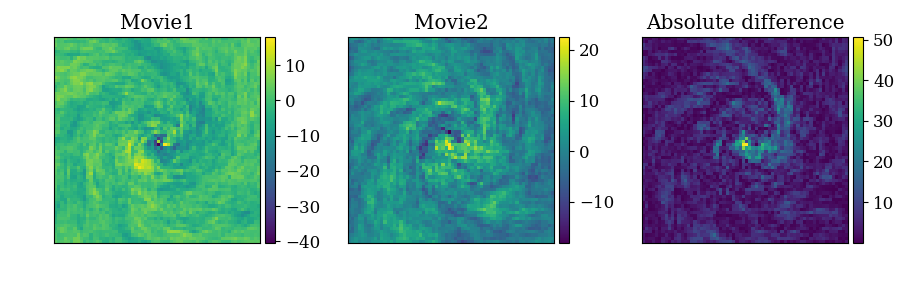

interactive(children=(IntSlider(value=24, description='i', max=49), Output()), _dom_classes=('widget-interact'…

In [17]:
%matplotlib notebook
compare_movie_frames(multi_sample[0], multi_sample[1])

<IPython.core.display.Javascript object>


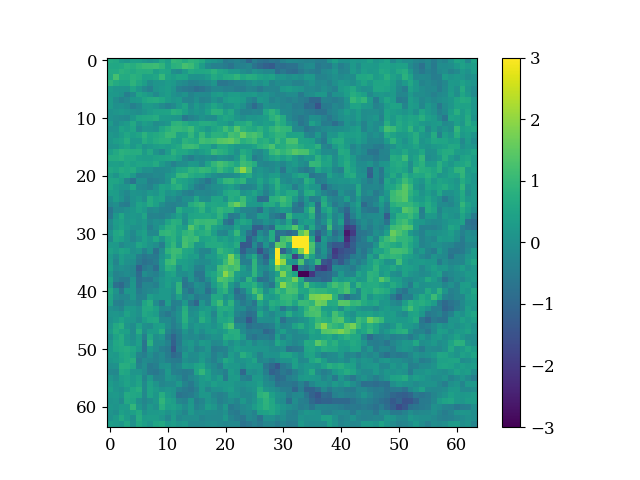

In [20]:
multi_sample.mean().get_animation(vmin=-3, vmax=3)

<IPython.core.display.Javascript object>


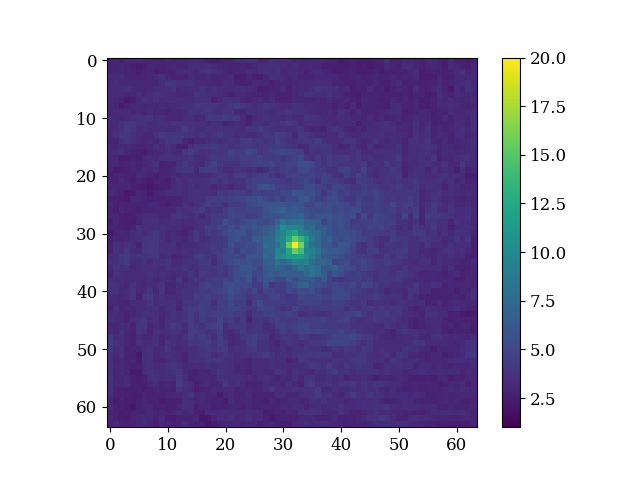

In [24]:
multi_sample.std().get_animation(vmin=1, vmax=20)

In [ ]:
n_jobs = 12
num_samples = 1000
solver = pynoisy.SamplerPDESolver(pynoisy.DiskAdvection(), pynoisy.RingDiffusion(), num_samples=num_samples)
multi_sample = solver.run(n_jobs=n_jobs)

In [ ]:
mean = np.array([movie.frames.mean() for movie in multi_sample])
mean_mean = mean.mean()
mean_std = mean.std()

plt.figure()
plt.plot(mean)
plt.title('Mean of random field', fontsize=18)
plt.xlabel('Simulation #', fontsize=14)
plt.axhline(mean_mean, linestyle='--', color='r')
plt.text(1002 ,mean_mean-0.5,'mean',rotation=90, color='r', fontsize=14)
plt.xlim([0, num_samples-1])

## Loss Analysis

In [3]:
# Generate synthetic measurements
advection_true = pynoisy.DiskAdvection()
diffusion_true = pynoisy.RingDiffusion()
solver_true = pynoisy.PDESolver(advection_true, diffusion_true)
measurements = solver_true.run(verbose=False)

### Mean square error

In [4]:
n_jobs = 12
num_samples = 50

solver = pynoisy.SamplerPDESolver(advection_true, diffusion_true, num_samples=num_samples)
angle_range = np.linspace(0, np.pi, 50)
loss_std, loss_mean = [], []

for angle in tqdm(angle_range):
    solver.set_diffusion(pynoisy.RingDiffusion(opening_angle=angle))
    solver.reseed()
    synthetic_measurements = solver.run(measurements.duration, n_jobs, verbose=False)
    error = np.abs(synthetic_measurements.frames - measurements.frames).mean(axis=(1,2,3))
    loss_mean.append(error.mean())
    loss_std.append(error.std())
    
loss_mean = np.array(loss_mean)
loss_std = np.array(loss_std)

Setting solver seed to: 17589


<IPython.core.display.Javascript object>


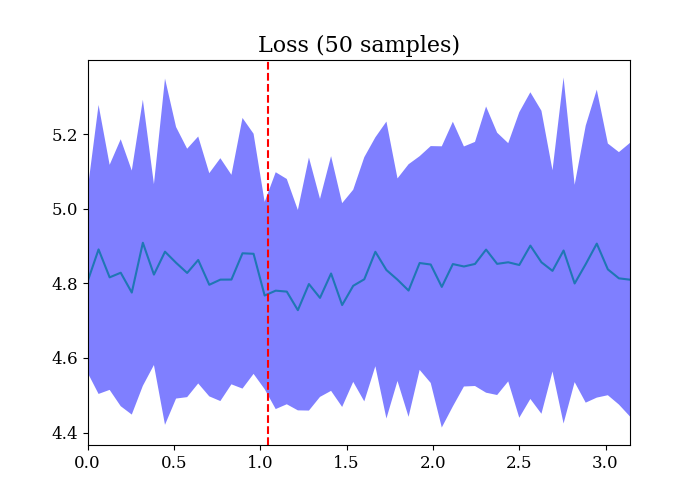

(0.0, 3.141592653589793)

In [6]:
%matplotlib notebook
fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.set_title('Loss ({} samples)'.format(num_samples), fontsize=16)
ax.plot(angle_range, loss_mean)
ax.fill_between(angle_range, loss_mean + loss_std, loss_mean - loss_std, facecolor='blue', alpha=0.5)
ax.axvline(diffusion_true.opening_angle, color='r', linestyle='--')
ax.set_xlim([angle_range[0], angle_range[-1]])

### Noise PCA

In [25]:
# Generate synthetic measurements
advection_true = pynoisy.DiskAdvection()
diffusion_true = pynoisy.RingDiffusion()
solver_true = pynoisy.PDESolver(advection_true, diffusion_true)
measurements = solver_true.run(verbose=False)

n_jobs = 60
num_samples = 120
n_components = 8
solver = pynoisy.SamplerPDESolver(advection_true, diffusion_true, num_samples=num_samples)
angle_range = np.linspace(0, 1.5*np.pi, 50)
loss = []

for angle in tqdm(angle_range):
    solver.set_diffusion(pynoisy.RingDiffusion(opening_angle=angle))
    solver.reseed()
    synthetic_measurements = solver.run(measurements.duration, n_jobs, verbose=False)
    X = synthetic_measurements.frames.reshape(solver.num_samples, -1)
    pca = PCA(n_components)
    pca.fit(X)
    components = pca.components_
    error = np.linalg.lstsq(components.T, measurements.frames.ravel(), rcond=None)[1]
    loss.append(error)
loss = np.array(loss)

In [36]:
%matplotlib notebook
fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.set_title('PCA({}) loss for {} samples per angle'.format(n_components, num_samples), fontsize=14)
ax.plot(angle_range, np.array(loss))
ax.axvline(diffusion_true.opening_angle, color='r', linestyle='--');
ax.set_xlabel(r'$\theta$ [rad]', fontsize=14)
ax.set_xlim([0.0, 1.5*np.pi]);

array([4887540.11417003])